In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

2024-12-07 12:00:49.976176: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 12:00:50.222694: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=128, target_width=128):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=32, target_height=128, target_width=128):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # 데이터셋 전처리 매핑
    dataset = dataset.map(lambda path, label: preprocess_image(path, label, target_height, target_width),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # 데이터 셔플 및 배치
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# 5. 학습 및 테스트 데이터셋 생성
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels, batch_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
import tensorflow as tf

model11 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    
    # 첫 번째 Convolutional Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 두 번째 Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 세 번째 Convolutional Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # Conv2D 층에서는 드롭아웃 1번만 사용

    # 네 번째 Convolutional Layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),

    # 첫 번째 Fully Connected Layer
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # 정규화 여기만 추가
    tf.keras.layers.Dropout(0.5),  # Fully Connected에서만 드롭아웃

    # Output Layer
    tf.keras.layers.Dense(7, activation='softmax')
])


In [14]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

In [15]:

# 모델 컴파일
model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [16]:
result11 =model11.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-05 01:55:25.930065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-05 01:55:36.027732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1687 of 10508
2024-12-05 01:55:46.027197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3353 of 10508
2024-12-05 01:55:56.024422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5015 of 10508
2024-12-05 01:56:06.024607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6696 of 10508
2024-12-05 01:56:16.027875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may ta

322/329 [============================>.] - ETA: 0s - loss: 1.9729 - accuracy: 0.2231

2024-12-05 01:56:41.378423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1691 of 4504
2024-12-05 01:56:51.383780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3405 of 4504
2024-12-05 01:56:57.956147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 89ms/step - loss: 1.9702 - accuracy: 0.2239 - val_loss: 1.7742 - val_accuracy: 0.3195
Epoch 2/50


2024-12-05 01:57:08.387799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1769 of 10508
2024-12-05 01:57:18.388729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3566 of 10508
2024-12-05 01:57:28.387419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5275 of 10508
2024-12-05 01:57:38.388961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7030 of 10508
2024-12-05 01:57:48.388317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8774 of 10508


 26/329 [=>............................] - ETA: 1s - loss: 1.7990 - accuracy: 0.2752 

2024-12-05 01:57:58.269128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.7912 - accuracy: 0.2923

2024-12-05 01:58:10.506420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1730 of 4504
2024-12-05 01:58:20.513567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3508 of 4504
2024-12-05 01:58:26.282110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 87ms/step - loss: 1.7911 - accuracy: 0.2923 - val_loss: 1.6780 - val_accuracy: 0.3621
Epoch 3/50


2024-12-05 01:58:36.720767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1722 of 10508
2024-12-05 01:58:46.728490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3511 of 10508
2024-12-05 01:58:56.722613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5174 of 10508
2024-12-05 01:59:06.754566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6901 of 10508
2024-12-05 01:59:16.721189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8622 of 10508
2024-12-05 01:59:26.727720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10420 of 10508


 26/329 [=>............................] - ETA: 1s - loss: 1.7604 - accuracy: 0.3221 

2024-12-05 01:59:27.234002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.7332 - accuracy: 0.3241

2024-12-05 01:59:39.369605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1769 of 4504
2024-12-05 01:59:49.366514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3554 of 4504
2024-12-05 01:59:54.804187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 85ms/step - loss: 1.7321 - accuracy: 0.3254 - val_loss: 1.6232 - val_accuracy: 0.3839
Epoch 4/50


2024-12-05 02:00:05.256600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1779 of 10508
2024-12-05 02:00:15.254387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3579 of 10508
2024-12-05 02:00:25.260172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5322 of 10508
2024-12-05 02:00:35.259909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7051 of 10508
2024-12-05 02:00:45.255272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8826 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.7570 - accuracy: 0.3348 

2024-12-05 02:00:54.627595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.7063 - accuracy: 0.3406

2024-12-05 02:01:06.770981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1759 of 4504
2024-12-05 02:01:16.765214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3536 of 4504
2024-12-05 02:01:22.303092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 86ms/step - loss: 1.7058 - accuracy: 0.3413 - val_loss: 1.6258 - val_accuracy: 0.3985
Epoch 5/50


2024-12-05 02:01:32.721981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1730 of 10508
2024-12-05 02:01:42.723303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3526 of 10508
2024-12-05 02:01:52.721098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5252 of 10508
2024-12-05 02:02:02.723331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6919 of 10508
2024-12-05 02:02:12.731572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8656 of 10508
2024-12-05 02:02:22.723288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10448 of 10508


 26/329 [=>............................] - ETA: 1s - loss: 1.6806 - accuracy: 0.3558 

2024-12-05 02:02:23.083322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.6863 - accuracy: 0.3583

2024-12-05 02:02:35.218469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1739 of 4504
2024-12-05 02:02:45.214876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3518 of 4504
2024-12-05 02:02:50.924961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 86ms/step - loss: 1.6842 - accuracy: 0.3593 - val_loss: 1.5131 - val_accuracy: 0.4303
Epoch 6/50


2024-12-05 02:03:01.352198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1741 of 10508
2024-12-05 02:03:11.358614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3546 of 10508
2024-12-05 02:03:21.356494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5287 of 10508
2024-12-05 02:03:31.354813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7028 of 10508
2024-12-05 02:03:41.350835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8787 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.6227 - accuracy: 0.3866 

2024-12-05 02:03:51.187599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.6367 - accuracy: 0.3794

2024-12-05 02:04:03.370965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1653 of 4504
2024-12-05 02:04:13.364123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3362 of 4504
2024-12-05 02:04:20.139642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 89ms/step - loss: 1.6367 - accuracy: 0.3795 - val_loss: 1.5624 - val_accuracy: 0.4496
Epoch 7/50


2024-12-05 02:05:23.264749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1645 of 10508
2024-12-05 02:05:33.266458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3393 of 10508
2024-12-05 02:05:43.263657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5060 of 10508
2024-12-05 02:05:53.275883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6715 of 10508
2024-12-05 02:06:03.269181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8433 of 10508
2024-12-05 02:06:13.268954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10173 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.6409 - accuracy: 0.3836 

2024-12-05 02:06:15.122153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.6135 - accuracy: 0.3897

2024-12-05 02:06:27.191431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1739 of 4504
2024-12-05 02:06:37.183869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3538 of 4504
2024-12-05 02:06:42.627120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 85ms/step - loss: 1.6139 - accuracy: 0.3896 - val_loss: 1.4780 - val_accuracy: 0.4858
Epoch 8/50


2024-12-05 02:06:53.035703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1787 of 10508
2024-12-05 02:07:03.027965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3610 of 10508
2024-12-05 02:07:13.031908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5379 of 10508
2024-12-05 02:07:23.038854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7129 of 10508
2024-12-05 02:07:33.035861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8898 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.6051 - accuracy: 0.4052 

2024-12-05 02:07:41.960813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.5732 - accuracy: 0.4156

2024-12-05 02:07:54.084614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1791 of 4504
2024-12-05 02:08:04.079167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3595 of 4504
2024-12-05 02:08:09.272584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 84ms/step - loss: 1.5737 - accuracy: 0.4158 - val_loss: 1.4623 - val_accuracy: 0.4876
Epoch 9/50


2024-12-05 02:08:19.674729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1800 of 10508
2024-12-05 02:08:29.674379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3589 of 10508
2024-12-05 02:08:39.682921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5329 of 10508
2024-12-05 02:08:49.674114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7096 of 10508
2024-12-05 02:08:59.674868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8883 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.5374 - accuracy: 0.4256 

2024-12-05 02:09:08.681243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.5580 - accuracy: 0.4294

2024-12-05 02:09:20.753669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1786 of 4504
2024-12-05 02:09:30.747959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3578 of 4504
2024-12-05 02:09:36.076377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 85ms/step - loss: 1.5572 - accuracy: 0.4295 - val_loss: 1.4290 - val_accuracy: 0.5155
Epoch 10/50


2024-12-05 02:09:46.467292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1787 of 10508
2024-12-05 02:09:56.467123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3610 of 10508
2024-12-05 02:10:06.501026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5366 of 10508
2024-12-05 02:10:16.462301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7125 of 10508
2024-12-05 02:10:26.467334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8936 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.5587 - accuracy: 0.4127 

2024-12-05 02:10:35.234755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.5372 - accuracy: 0.4308

2024-12-05 02:10:47.327451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1759 of 4504
2024-12-05 02:10:57.332943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3575 of 4504
2024-12-05 02:11:02.627956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 85ms/step - loss: 1.5377 - accuracy: 0.4306 - val_loss: 1.3718 - val_accuracy: 0.5275
Epoch 11/50


2024-12-05 02:11:13.021730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1745 of 10508
2024-12-05 02:11:23.023724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3572 of 10508
2024-12-05 02:11:33.020479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5313 of 10508
2024-12-05 02:11:43.023878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7086 of 10508
2024-12-05 02:11:53.023188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8882 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.5150 - accuracy: 0.4780 

2024-12-05 02:12:02.068587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.5163 - accuracy: 0.4474

2024-12-05 02:12:14.145975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1789 of 4504
2024-12-05 02:12:24.145495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3614 of 4504
2024-12-05 02:12:29.230906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 84ms/step - loss: 1.5168 - accuracy: 0.4475 - val_loss: 1.3563 - val_accuracy: 0.5377
Epoch 12/50


2024-12-05 02:12:39.616551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1785 of 10508
2024-12-05 02:12:49.613857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3588 of 10508
2024-12-05 02:12:59.613104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5364 of 10508
2024-12-05 02:13:09.627858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7108 of 10508
2024-12-05 02:13:19.615635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8911 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.4593 - accuracy: 0.4554 

2024-12-05 02:13:28.457997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.4844 - accuracy: 0.4545

2024-12-05 02:13:40.568109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1782 of 4504
2024-12-05 02:13:50.564664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3572 of 4504
2024-12-05 02:13:55.806146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 85ms/step - loss: 1.4855 - accuracy: 0.4552 - val_loss: 1.3770 - val_accuracy: 0.5411
Epoch 13/50


2024-12-05 02:14:06.208581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1772 of 10508
2024-12-05 02:14:16.205652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3539 of 10508
2024-12-05 02:14:26.201687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5295 of 10508
2024-12-05 02:14:36.201557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7005 of 10508
2024-12-05 02:14:46.204185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8743 of 10508


 20/329 [>.............................] - ETA: 1s - loss: 1.4112 - accuracy: 0.5016   

2024-12-05 02:14:56.200821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10499 of 10508
2024-12-05 02:14:56.246428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.4767 - accuracy: 0.4629

2024-12-05 02:15:08.311665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1761 of 4504
2024-12-05 02:15:18.311198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3535 of 4504
2024-12-05 02:15:23.857904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 85ms/step - loss: 1.4773 - accuracy: 0.4625 - val_loss: 1.3198 - val_accuracy: 0.5480
Epoch 14/50


2024-12-05 02:15:34.266773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1737 of 10508
2024-12-05 02:15:44.264052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3523 of 10508
2024-12-05 02:15:54.272327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5262 of 10508
2024-12-05 02:16:04.263945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7014 of 10508
2024-12-05 02:16:14.262905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8785 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.4708 - accuracy: 0.4709 

2024-12-05 02:16:23.845849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.4639 - accuracy: 0.4719

2024-12-05 02:16:35.894650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1774 of 4504
2024-12-05 02:16:45.901236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3581 of 4504
2024-12-05 02:16:51.162020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 84ms/step - loss: 1.4639 - accuracy: 0.4716 - val_loss: 1.3449 - val_accuracy: 0.5504
Epoch 15/50


2024-12-05 02:17:01.555736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1786 of 10508
2024-12-05 02:17:11.555329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3584 of 10508
2024-12-05 02:17:21.560427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5329 of 10508
2024-12-05 02:17:31.562908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7071 of 10508
2024-12-05 02:17:41.559398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8857 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.4589 - accuracy: 0.4877 

2024-12-05 02:17:50.703318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.4451 - accuracy: 0.4840

2024-12-05 02:18:02.752058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1799 of 4504
2024-12-05 02:18:12.762835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3612 of 4504
2024-12-05 02:18:17.789896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 84ms/step - loss: 1.4438 - accuracy: 0.4844 - val_loss: 1.3316 - val_accuracy: 0.5493
Epoch 16/50


2024-12-05 02:18:28.199885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1787 of 10508
2024-12-05 02:18:38.196819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3597 of 10508
2024-12-05 02:18:48.202716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5354 of 10508
2024-12-05 02:18:58.194863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7103 of 10508
2024-12-05 02:19:08.203425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8864 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.3540 - accuracy: 0.5011 

2024-12-05 02:19:17.408971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.4214 - accuracy: 0.4887

2024-12-05 02:19:29.468766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1745 of 4504
2024-12-05 02:19:39.472405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3550 of 4504
2024-12-05 02:19:45.190035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 86ms/step - loss: 1.4209 - accuracy: 0.4884 - val_loss: 1.3299 - val_accuracy: 0.5420
Epoch 17/50


2024-12-05 02:19:55.652282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1751 of 10508
2024-12-05 02:20:05.656424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3430 of 10508
2024-12-05 02:20:15.646974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5074 of 10508
2024-12-05 02:20:25.645328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6728 of 10508
2024-12-05 02:20:35.653314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8383 of 10508
2024-12-05 02:20:45.650594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10080 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.3822 - accuracy: 0.5026 

2024-12-05 02:20:48.345792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.4064 - accuracy: 0.4943

2024-12-05 02:21:00.752850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1688 of 4504
2024-12-05 02:21:10.748470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3382 of 4504
2024-12-05 02:21:17.416211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 90ms/step - loss: 1.4073 - accuracy: 0.4941 - val_loss: 1.3017 - val_accuracy: 0.5573
Epoch 18/50


2024-12-05 02:21:27.966989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1671 of 10508
2024-12-05 02:21:37.970246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3358 of 10508
2024-12-05 02:21:47.967007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4993 of 10508
2024-12-05 02:21:57.976443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6657 of 10508
2024-12-05 02:22:07.971903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8242 of 10508
2024-12-05 02:22:17.969825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9939 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.4609 - accuracy: 0.4796 

2024-12-05 02:22:21.245331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.3957 - accuracy: 0.5056

2024-12-05 02:22:33.708934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1617 of 4504
2024-12-05 02:22:43.711987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3292 of 4504
2024-12-05 02:22:51.041810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 94s 93ms/step - loss: 1.3954 - accuracy: 0.5055 - val_loss: 1.2946 - val_accuracy: 0.5782
Epoch 19/50


2024-12-05 02:23:49.888131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1638 of 10508
2024-12-05 02:23:59.892100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3338 of 10508
2024-12-05 02:24:09.887834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4953 of 10508
2024-12-05 02:24:19.887184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6649 of 10508
2024-12-05 02:24:29.899415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8281 of 10508
2024-12-05 02:24:39.894971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10026 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.4036 - accuracy: 0.5216 

2024-12-05 02:24:42.484310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.3848 - accuracy: 0.5139

2024-12-05 02:24:54.535732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1797 of 4504
2024-12-05 02:25:04.539216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3606 of 4504
2024-12-05 02:25:09.654465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 84ms/step - loss: 1.3854 - accuracy: 0.5131 - val_loss: 1.2851 - val_accuracy: 0.5702
Epoch 20/50


2024-12-05 02:25:20.045666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1806 of 10508
2024-12-05 02:25:30.058474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3633 of 10508
2024-12-05 02:25:40.044974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5390 of 10508
2024-12-05 02:25:50.045862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7127 of 10508
2024-12-05 02:26:00.046964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8915 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.3512 - accuracy: 0.5045 

2024-12-05 02:26:09.034135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.3743 - accuracy: 0.5149

2024-12-05 02:26:21.092704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1773 of 4504
2024-12-05 02:26:31.092808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3577 of 4504
2024-12-05 02:26:36.335257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 84ms/step - loss: 1.3745 - accuracy: 0.5153 - val_loss: 1.2790 - val_accuracy: 0.5735
Epoch 21/50


2024-12-05 02:26:46.754094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1798 of 10508
2024-12-05 02:26:56.746881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3619 of 10508
2024-12-05 02:27:06.750472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5389 of 10508
2024-12-05 02:27:16.742860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7152 of 10508
2024-12-05 02:27:26.749017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8965 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.3366 - accuracy: 0.5377 

2024-12-05 02:27:35.287196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


321/329 [============================>.] - ETA: 0s - loss: 1.3425 - accuracy: 0.5351

2024-12-05 02:27:47.310139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1782 of 4504
2024-12-05 02:27:57.308522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3595 of 4504
2024-12-05 02:28:02.473170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 84ms/step - loss: 1.3442 - accuracy: 0.5352 - val_loss: 1.2848 - val_accuracy: 0.5779
Epoch 22/50


2024-12-05 02:28:12.866449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1793 of 10508
2024-12-05 02:28:22.875781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3631 of 10508
2024-12-05 02:28:32.872227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5366 of 10508
2024-12-05 02:28:42.869214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7096 of 10508
2024-12-05 02:28:52.867858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8857 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.2717 - accuracy: 0.5637 

2024-12-05 02:29:01.999292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


321/329 [============================>.] - ETA: 0s - loss: 1.3337 - accuracy: 0.5349

2024-12-05 02:29:14.078487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1764 of 4504
2024-12-05 02:29:24.078367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3563 of 4504
2024-12-05 02:29:29.460930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 85ms/step - loss: 1.3332 - accuracy: 0.5357 - val_loss: 1.2692 - val_accuracy: 0.5750
Epoch 23/50


2024-12-05 02:29:39.853619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1780 of 10508
2024-12-05 02:29:49.853903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3548 of 10508
2024-12-05 02:29:59.858145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5299 of 10508
2024-12-05 02:30:09.852232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6966 of 10508
2024-12-05 02:30:19.853100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8626 of 10508
2024-12-05 02:30:29.860986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10332 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.3405 - accuracy: 0.5156 

2024-12-05 02:30:30.888570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.3102 - accuracy: 0.5452

2024-12-05 02:30:43.382429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1674 of 4504
2024-12-05 02:30:53.374045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3321 of 4504
2024-12-05 02:31:00.490302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 91s 92ms/step - loss: 1.3109 - accuracy: 0.5451 - val_loss: 1.2704 - val_accuracy: 0.5748
Epoch 24/50


2024-12-05 02:32:01.771095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1669 of 10508
2024-12-05 02:32:11.770067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3369 of 10508
2024-12-05 02:32:21.766465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5036 of 10508
2024-12-05 02:32:31.771665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6673 of 10508
2024-12-05 02:32:41.769414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8304 of 10508
2024-12-05 02:32:51.775937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9987 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.3009 - accuracy: 0.5284 

2024-12-05 02:32:54.788983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.3076 - accuracy: 0.5476

2024-12-05 02:33:07.286413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1664 of 4504
2024-12-05 02:33:17.291161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3358 of 4504
2024-12-05 02:33:24.383894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 1.3087 - accuracy: 0.5474 - val_loss: 1.2645 - val_accuracy: 0.5799
Epoch 25/50


2024-12-05 02:33:34.965969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1667 of 10508
2024-12-05 02:33:44.974838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3375 of 10508
2024-12-05 02:33:54.965641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5009 of 10508
2024-12-05 02:34:04.963748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6669 of 10508
2024-12-05 02:34:14.964047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8251 of 10508
2024-12-05 02:34:24.971496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9942 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.2332 - accuracy: 0.5774 

2024-12-05 02:34:28.301545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.2853 - accuracy: 0.5528

2024-12-05 02:34:40.775333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1674 of 4504
2024-12-05 02:34:50.777356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3350 of 4504
2024-12-05 02:34:57.848501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 1.2856 - accuracy: 0.5531 - val_loss: 1.2722 - val_accuracy: 0.5866
Epoch 26/50


2024-12-05 02:35:08.381757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1590 of 10508
2024-12-05 02:35:18.382076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3276 of 10508
2024-12-05 02:35:28.380465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4909 of 10508
2024-12-05 02:35:38.378426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6582 of 10508
2024-12-05 02:35:48.411252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8163 of 10508
2024-12-05 02:35:58.381229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9834 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.2521 - accuracy: 0.5516 

2024-12-05 02:36:02.367275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.2717 - accuracy: 0.5650

2024-12-05 02:36:14.877246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1623 of 4504
2024-12-05 02:36:24.883572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3282 of 4504
2024-12-05 02:36:32.337687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 95s 93ms/step - loss: 1.2718 - accuracy: 0.5648 - val_loss: 1.2940 - val_accuracy: 0.5775
Epoch 27/50


2024-12-05 02:36:42.893412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1628 of 10508
2024-12-05 02:36:52.895168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3319 of 10508
2024-12-05 02:37:02.892185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4971 of 10508
2024-12-05 02:37:12.894690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6647 of 10508
2024-12-05 02:37:22.891603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8299 of 10508
2024-12-05 02:37:32.898743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9944 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.2334 - accuracy: 0.5511 

2024-12-05 02:37:36.159778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.2554 - accuracy: 0.5670

2024-12-05 02:37:48.656824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1661 of 4504
2024-12-05 02:37:58.658286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3350 of 4504
2024-12-05 02:38:05.507971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.2536 - accuracy: 0.5687 - val_loss: 1.2617 - val_accuracy: 0.5886
Epoch 28/50


2024-12-05 02:38:16.060005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1681 of 10508
2024-12-05 02:38:26.062144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3353 of 10508
2024-12-05 02:38:36.064718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4992 of 10508
2024-12-05 02:38:46.066688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6675 of 10508
2024-12-05 02:38:56.061421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8317 of 10508
2024-12-05 02:39:06.062314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10004 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.2404 - accuracy: 0.5569 

2024-12-05 02:39:09.264358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.2467 - accuracy: 0.5733

2024-12-05 02:39:21.565514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1677 of 4504
2024-12-05 02:39:31.565080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3350 of 4504
2024-12-05 02:39:38.487361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.2487 - accuracy: 0.5724 - val_loss: 1.2572 - val_accuracy: 0.5968
Epoch 29/50


2024-12-05 02:39:49.069211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1683 of 10508
2024-12-05 02:39:59.058683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3418 of 10508
2024-12-05 02:40:09.060485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5023 of 10508
2024-12-05 02:40:19.065782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6709 of 10508
2024-12-05 02:40:29.059898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8371 of 10508
2024-12-05 02:40:39.062081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10044 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.2338 - accuracy: 0.5852 

2024-12-05 02:40:41.708679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.2285 - accuracy: 0.5826

2024-12-05 02:40:54.227065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1683 of 4504
2024-12-05 02:41:04.229385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3343 of 4504
2024-12-05 02:41:11.249961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 1.2284 - accuracy: 0.5828 - val_loss: 1.2338 - val_accuracy: 0.6041
Epoch 30/50


2024-12-05 02:41:21.794142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1663 of 10508
2024-12-05 02:41:31.794841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3369 of 10508
2024-12-05 02:41:41.793818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4997 of 10508
2024-12-05 02:41:51.799336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6649 of 10508
2024-12-05 02:42:01.796588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8298 of 10508
2024-12-05 02:42:11.803211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9980 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.1985 - accuracy: 0.6168 

2024-12-05 02:42:14.837795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.2263 - accuracy: 0.5894

2024-12-05 02:42:27.243030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1695 of 4504
2024-12-05 02:42:37.243974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3386 of 4504
2024-12-05 02:42:44.042750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.2262 - accuracy: 0.5896 - val_loss: 1.2314 - val_accuracy: 0.6044
Epoch 31/50


2024-12-05 02:42:54.595318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1670 of 10508
2024-12-05 02:43:04.595001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3386 of 10508
2024-12-05 02:43:14.597397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5051 of 10508
2024-12-05 02:43:24.607699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6728 of 10508
2024-12-05 02:43:34.601226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8373 of 10508
2024-12-05 02:43:44.598810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10080 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.2059 - accuracy: 0.5856 

2024-12-05 02:43:47.015047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.2014 - accuracy: 0.5963

2024-12-05 02:43:59.437632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1707 of 4504
2024-12-05 02:44:09.435956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3423 of 4504
2024-12-05 02:44:15.861534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 90ms/step - loss: 1.2020 - accuracy: 0.5955 - val_loss: 1.2005 - val_accuracy: 0.6106
Epoch 32/50


2024-12-05 02:44:26.433536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1665 of 10508
2024-12-05 02:44:36.432811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3382 of 10508
2024-12-05 02:44:46.432991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5058 of 10508
2024-12-05 02:44:56.434331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6730 of 10508
2024-12-05 02:45:06.433930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8409 of 10508
2024-12-05 02:45:16.433592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10074 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.1058 - accuracy: 0.6392 

2024-12-05 02:45:18.909061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.1775 - accuracy: 0.6137

2024-12-05 02:45:31.440789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1684 of 4504
2024-12-05 02:45:41.438475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3369 of 4504
2024-12-05 02:45:48.333773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 91ms/step - loss: 1.1764 - accuracy: 0.6137 - val_loss: 1.2234 - val_accuracy: 0.6075
Epoch 33/50


2024-12-05 02:46:48.343386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1695 of 10508
2024-12-05 02:46:58.348045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3419 of 10508
2024-12-05 02:47:08.353671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5066 of 10508
2024-12-05 02:47:18.343388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6753 of 10508
2024-12-05 02:47:28.353164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8442 of 10508
2024-12-05 02:47:38.347652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10142 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.1405 - accuracy: 0.6185 

2024-12-05 02:47:40.444688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.1751 - accuracy: 0.6113

2024-12-05 02:47:52.943536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1665 of 4504
2024-12-05 02:48:02.943693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3377 of 4504
2024-12-05 02:48:09.636381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 91ms/step - loss: 1.1748 - accuracy: 0.6112 - val_loss: 1.2127 - val_accuracy: 0.6150
Epoch 34/50


2024-12-05 02:49:10.258697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1687 of 10508
2024-12-05 02:49:20.262085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3426 of 10508
2024-12-05 02:49:30.256956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5071 of 10508
2024-12-05 02:49:40.255196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6749 of 10508
2024-12-05 02:49:50.256070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8426 of 10508
2024-12-05 02:50:00.254666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10139 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.1021 - accuracy: 0.6386 

2024-12-05 02:50:02.359340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.1554 - accuracy: 0.6240

2024-12-05 02:50:14.831809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1670 of 4504
2024-12-05 02:50:24.833420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3348 of 4504
2024-12-05 02:50:31.745410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 91ms/step - loss: 1.1582 - accuracy: 0.6226 - val_loss: 1.2092 - val_accuracy: 0.6188
Epoch 35/50


2024-12-05 02:51:32.177387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1675 of 10508
2024-12-05 02:51:42.168485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3404 of 10508
2024-12-05 02:51:52.166858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5059 of 10508
2024-12-05 02:52:02.176648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6715 of 10508
2024-12-05 02:52:12.166305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8362 of 10508
2024-12-05 02:52:22.168929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10070 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.1018 - accuracy: 0.6345 

2024-12-05 02:52:24.662704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.1321 - accuracy: 0.6287

2024-12-05 02:52:37.163702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1691 of 4504
2024-12-05 02:52:47.171622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3407 of 4504
2024-12-05 02:52:53.838090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 91ms/step - loss: 1.1327 - accuracy: 0.6284 - val_loss: 1.1832 - val_accuracy: 0.6217
Epoch 36/50


2024-12-05 02:53:54.086450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1689 of 10508
2024-12-05 02:54:04.080066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3420 of 10508
2024-12-05 02:54:14.080638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5095 of 10508
2024-12-05 02:54:24.082859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6773 of 10508
2024-12-05 02:54:34.080474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8406 of 10508
2024-12-05 02:54:44.084024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10106 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0327 - accuracy: 0.6522 

2024-12-05 02:54:46.380709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.1399 - accuracy: 0.6274

2024-12-05 02:54:58.907083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1695 of 4504
2024-12-05 02:55:08.893851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3392 of 4504
2024-12-05 02:55:15.499194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 90ms/step - loss: 1.1391 - accuracy: 0.6276 - val_loss: 1.2622 - val_accuracy: 0.6088
Epoch 37/50


2024-12-05 02:55:26.079576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1652 of 10508
2024-12-05 02:55:36.079401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3367 of 10508
2024-12-05 02:55:46.071654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5034 of 10508
2024-12-05 02:55:56.082678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6717 of 10508
2024-12-05 02:56:06.077300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8391 of 10508
2024-12-05 02:56:16.078548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10066 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.1076 - accuracy: 0.6392 

2024-12-05 02:56:18.595683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.1092 - accuracy: 0.6345

2024-12-05 02:56:31.072896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1695 of 4504
2024-12-05 02:56:41.070769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3413 of 4504
2024-12-05 02:56:47.588893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 90ms/step - loss: 1.1099 - accuracy: 0.6342 - val_loss: 1.2029 - val_accuracy: 0.6234
Epoch 38/50


2024-12-05 02:57:47.990135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1659 of 10508
2024-12-05 02:57:57.985736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3361 of 10508
2024-12-05 02:58:07.986644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5045 of 10508
2024-12-05 02:58:17.986290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6731 of 10508
2024-12-05 02:58:27.991871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8414 of 10508
2024-12-05 02:58:37.992010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10124 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0374 - accuracy: 0.6658 

2024-12-05 02:58:40.293501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.1036 - accuracy: 0.6417

2024-12-05 02:58:52.713787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1665 of 4504
2024-12-05 02:59:02.720258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3367 of 4504
2024-12-05 02:59:09.499792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 91ms/step - loss: 1.1030 - accuracy: 0.6417 - val_loss: 1.1931 - val_accuracy: 0.6163
Epoch 39/50


2024-12-05 02:59:20.057952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1697 of 10508
2024-12-05 02:59:30.058336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3411 of 10508
2024-12-05 02:59:40.060442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5072 of 10508
2024-12-05 02:59:50.063165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6731 of 10508
2024-12-05 03:00:00.061960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8397 of 10508
2024-12-05 03:00:10.067206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9948 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.0436 - accuracy: 0.6506 

2024-12-05 03:00:13.406130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.1011 - accuracy: 0.6450

2024-12-05 03:00:25.907068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1522 of 4504
2024-12-05 03:00:35.902113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3188 of 4504
2024-12-05 03:00:44.357041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 95s 96ms/step - loss: 1.1011 - accuracy: 0.6451 - val_loss: 1.2169 - val_accuracy: 0.6141
Epoch 40/50


2024-12-05 03:00:54.937959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1605 of 10508
2024-12-05 03:01:04.932054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3203 of 10508
2024-12-05 03:01:14.935490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4781 of 10508
2024-12-05 03:01:24.931452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6367 of 10508
2024-12-05 03:01:34.932629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7851 of 10508
2024-12-05 03:01:44.931821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9459 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0455 - accuracy: 0.6753 

2024-12-05 03:01:51.870116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.0950 - accuracy: 0.6501

2024-12-05 03:02:04.361606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1606 of 4504
2024-12-05 03:02:14.368799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3196 of 4504
2024-12-05 03:02:22.566889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 98s 95ms/step - loss: 1.0970 - accuracy: 0.6491 - val_loss: 1.2211 - val_accuracy: 0.6146
Epoch 41/50


2024-12-05 03:03:16.857198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1592 of 10508
2024-12-05 03:03:26.854137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3235 of 10508
2024-12-05 03:03:36.847714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4767 of 10508
2024-12-05 03:03:46.851492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6320 of 10508
2024-12-05 03:03:56.859508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7907 of 10508
2024-12-05 03:04:06.858228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9530 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 1.0966 - accuracy: 0.6675 

2024-12-05 03:04:12.849808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.0677 - accuracy: 0.6559

2024-12-05 03:04:25.273522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1607 of 4504
2024-12-05 03:04:35.277981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3237 of 4504
2024-12-05 03:04:43.209546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 97s 94ms/step - loss: 1.0677 - accuracy: 0.6559 - val_loss: 1.2424 - val_accuracy: 0.6208
Epoch 42/50


2024-12-05 03:04:53.757689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1576 of 10508
2024-12-05 03:05:03.752299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3245 of 10508
2024-12-05 03:05:13.759098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4851 of 10508
2024-12-05 03:05:23.758561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6535 of 10508
2024-12-05 03:05:33.753644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8179 of 10508
2024-12-05 03:05:43.754803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9860 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0231 - accuracy: 0.6522 

2024-12-05 03:05:47.557769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.0502 - accuracy: 0.6618

2024-12-05 03:06:00.005498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1627 of 4504
2024-12-05 03:06:10.000960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3324 of 4504
2024-12-05 03:06:17.153473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 94s 92ms/step - loss: 1.0505 - accuracy: 0.6615 - val_loss: 1.2123 - val_accuracy: 0.6197
Epoch 43/50


2024-12-05 03:06:27.733136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1658 of 10508
2024-12-05 03:06:37.737366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3375 of 10508
2024-12-05 03:06:47.732688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5021 of 10508
2024-12-05 03:06:57.737350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6677 of 10508
2024-12-05 03:07:07.737405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8249 of 10508
2024-12-05 03:07:17.733215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9942 of 10508


 21/329 [>.............................] - ETA: 2s - loss: 0.9981 - accuracy: 0.6711 

2024-12-05 03:07:21.016520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.6639

2024-12-05 03:07:33.491747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1674 of 4504
2024-12-05 03:07:43.488916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3361 of 4504
2024-12-05 03:07:50.398752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.0395 - accuracy: 0.6643 - val_loss: 1.2650 - val_accuracy: 0.6188
Epoch 44/50


2024-12-05 03:08:00.974927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1671 of 10508
2024-12-05 03:08:10.984348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3336 of 10508
2024-12-05 03:08:20.977766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4984 of 10508
2024-12-05 03:08:30.977962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6617 of 10508
2024-12-05 03:08:40.979982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8270 of 10508
2024-12-05 03:08:50.978805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9953 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0434 - accuracy: 0.6671 

2024-12-05 03:08:54.193283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.0546 - accuracy: 0.6628

2024-12-05 03:09:06.718168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1657 of 4504
2024-12-05 03:09:16.716288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3357 of 4504
2024-12-05 03:09:23.564125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.0543 - accuracy: 0.6627 - val_loss: 1.2228 - val_accuracy: 0.6246
Epoch 45/50


2024-12-05 03:09:34.131649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1674 of 10508
2024-12-05 03:09:44.138760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3402 of 10508
2024-12-05 03:09:54.131021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5049 of 10508
2024-12-05 03:10:04.130286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6706 of 10508
2024-12-05 03:10:14.131157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8281 of 10508
2024-12-05 03:10:24.142935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9963 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0385 - accuracy: 0.6427 

2024-12-05 03:10:27.314717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.0291 - accuracy: 0.6714

2024-12-05 03:10:39.820696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1661 of 4504
2024-12-05 03:10:49.815801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3348 of 4504
2024-12-05 03:10:56.673543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 91ms/step - loss: 1.0287 - accuracy: 0.6715 - val_loss: 1.2708 - val_accuracy: 0.6148
Epoch 46/50


2024-12-05 03:11:07.237923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1687 of 10508
2024-12-05 03:11:17.233258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3396 of 10508
2024-12-05 03:11:27.233351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5029 of 10508
2024-12-05 03:11:37.234101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6701 of 10508
2024-12-05 03:11:47.235032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8327 of 10508
2024-12-05 03:11:57.231768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10020 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.0312 - accuracy: 0.6628 

2024-12-05 03:12:00.031740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.0256 - accuracy: 0.6689

2024-12-05 03:12:12.489285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1664 of 4504
2024-12-05 03:12:22.487030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3348 of 4504
2024-12-05 03:12:29.638472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 1.0257 - accuracy: 0.6685 - val_loss: 1.2726 - val_accuracy: 0.6175
Epoch 47/50


2024-12-05 03:13:29.146990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1620 of 10508
2024-12-05 03:13:39.148962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3325 of 10508
2024-12-05 03:13:49.150524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4961 of 10508
2024-12-05 03:13:59.145809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6646 of 10508
2024-12-05 03:14:09.147424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8281 of 10508
2024-12-05 03:14:19.151900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9983 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 0.9557 - accuracy: 0.7088 

2024-12-05 03:14:22.183753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.9990 - accuracy: 0.6853

2024-12-05 03:14:34.635377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1613 of 4504
2024-12-05 03:14:44.624873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3304 of 4504
2024-12-05 03:14:51.978790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 1.0000 - accuracy: 0.6845 - val_loss: 1.2206 - val_accuracy: 0.6286
Epoch 48/50


2024-12-05 03:15:02.535535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1685 of 10508
2024-12-05 03:15:12.536836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3391 of 10508
2024-12-05 03:15:22.534153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5059 of 10508
2024-12-05 03:15:32.532257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6736 of 10508
2024-12-05 03:15:42.531894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8418 of 10508
2024-12-05 03:15:52.532782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10119 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 0.9863 - accuracy: 0.6889 

2024-12-05 03:15:54.749571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.9957 - accuracy: 0.6876

2024-12-05 03:16:07.007838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1704 of 4504
2024-12-05 03:16:17.013384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3425 of 4504
2024-12-05 03:16:23.446576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 91s 89ms/step - loss: 0.9955 - accuracy: 0.6877 - val_loss: 1.2187 - val_accuracy: 0.6365
Epoch 49/50


2024-12-05 03:16:33.978387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1683 of 10508
2024-12-05 03:16:43.974625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3400 of 10508
2024-12-05 03:16:53.971663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5060 of 10508
2024-12-05 03:17:03.972064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6728 of 10508
2024-12-05 03:17:13.974805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8359 of 10508
2024-12-05 03:17:23.976090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10062 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 0.9322 - accuracy: 0.7201 

2024-12-05 03:17:26.504085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.9805 - accuracy: 0.6904

2024-12-05 03:17:39.004818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1598 of 4504
2024-12-05 03:17:49.004162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3303 of 4504
2024-12-05 03:17:56.128526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 93s 92ms/step - loss: 0.9805 - accuracy: 0.6903 - val_loss: 1.2653 - val_accuracy: 0.6270
Epoch 50/50


2024-12-05 03:18:55.887002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1667 of 10508
2024-12-05 03:19:05.885100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3367 of 10508
2024-12-05 03:19:15.883188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5003 of 10508
2024-12-05 03:19:25.890019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6657 of 10508
2024-12-05 03:19:35.881169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8232 of 10508
2024-12-05 03:19:45.882758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9838 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 0.9593 - accuracy: 0.7003 

2024-12-05 03:19:50.210511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 0.9763 - accuracy: 0.6896

2024-12-05 03:20:02.716419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1616 of 4504
2024-12-05 03:20:12.727509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3257 of 4504
2024-12-05 03:20:20.738722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 95s 95ms/step - loss: 0.9757 - accuracy: 0.6898 - val_loss: 1.2690 - val_accuracy: 0.6297


In [17]:
# 모델 평가
score11 = model11.evaluate(test_dataset)
score11

2024-12-05 06:14:08.232066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1607 of 4504
2024-12-05 06:14:18.231103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3240 of 4504


 37/141 [======>.......................] - ETA: 0s - loss: 1.2986 - accuracy: 0.6225 

2024-12-05 06:14:26.099205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


141/141 [==============================] - 29s 4ms/step - loss: 1.2690 - accuracy: 0.6297


[1.2690339088439941, 0.6296625137329102]

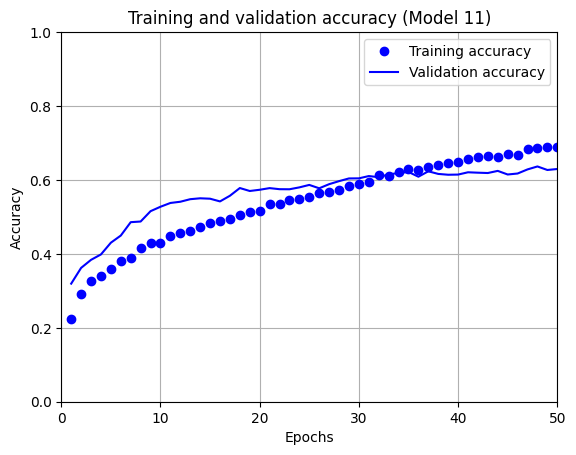

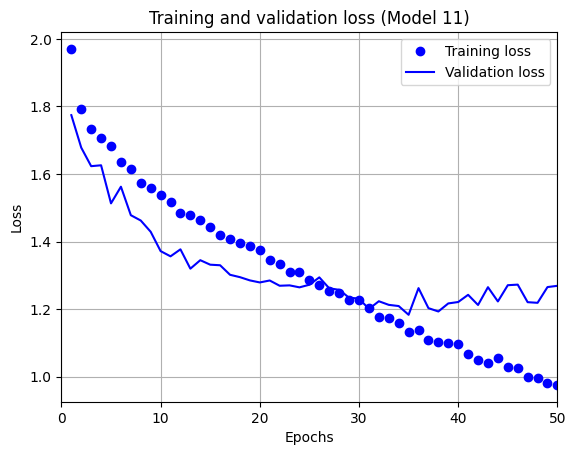

In [18]:
import matplotlib.pyplot as plt
acc11 = result11.history['accuracy']
val_acc11 = result11.history['val_accuracy']
loss11 = result11.history['loss']
val_loss11 = result11.history['val_loss']
epochs11 = range(1, len(acc11) + 1)

# Training and validation accuracy plot
plt.plot(epochs11, acc11, 'bo', label='Training accuracy')
plt.plot(epochs11, val_acc11, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 11)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs11, loss11, 'bo', label='Training loss')
plt.plot(epochs11, val_loss11, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 11)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

